# Problem I: Inverse Modeling with Neural Networks

## Learning Objectives

In this notebook, we explore a fundamental challenge in physics-informed machine learning: **inverse modeling**. Given observed data from a physical system, can we recover the underlying parameters that generated it?

We will:
1. Generate synthetic data from a known physical model (correlator function)
2. **Try I**: Attempt to recover parameters using a standard neural network approach
3. **Try II**: Learn from our mistakes and design a physics-informed architecture
4. Analyze why certain architectural choices succeed or fail

**Key Takeaway**: Low training loss does not guarantee correct parameter recovery. The network architecture must respect the physical structure of the problem.

## 1. The Physical Model

We consider a correlator function inspired by lattice QCD, modeled as a sum of exponentially decaying terms:

$$
C(x) = \sum_{i=1}^{15} A_i \cdot x^2 \cdot e^{-c_i \cdot x}
$$

where:
- $x \in [0, 50]$ represents Euclidean time separations
- $A_i \in [0.5, 4.0]$ are **fixed** amplitudes (15 values)
- $c_i \in [0.01, 10]$ are **fixed** positive decay constants (15 values)

**The Inverse Problem**: Given measurements of $C(x)$ at various points, can we recover the true values of $\{A_i\}$ and $\{c_i\}$?

This is challenging because:
- We have 30 unknown parameters
- The function is nonlinear in the parameters
- Multiple parameter combinations might produce similar $C(x)$ values

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### 1.1 Ground Truth Parameters

We randomly generate the "true" parameters that we will attempt to recover. These are the values our neural network should ideally learn.

In [2]:
# Number of exponential terms
n_terms = 15

# Ground truth parameters - THESE ARE WHAT WE WANT TO RECOVER
A_true = np.random.uniform(0.5, 4.0, size=n_terms)
c_true = np.random.uniform(0.01, 10.0, size=n_terms)

print("="*60)
print("GROUND TRUTH PARAMETERS (to be recovered)")
print("="*60)
print(f"\nAmplitudes A_i:\n{np.round(A_true, 4)}")
print()
print(f"Decay constants c_i:\n{np.round(c_true, 4)}")
print()
print(f"\nA range:\n[{A_true.min():.3f}, {A_true.max():.3f}]")
print()
print(f"c range:\n[{c_true.min():.4f}, {c_true.max():.4f}]")

GROUND TRUTH PARAMETERS (to be recovered)

Amplitudes A_i:
[1.8109 3.8275 3.062  2.5953 1.0461 1.046  0.7033 3.5316 2.6039 2.9783
 0.572  3.8947 3.4135 1.2432 1.1364]

Decay constants c_i:
[1.8422 3.0494 5.2523 4.3251 2.9194 6.1224 1.4035 2.9285 3.67   4.5661
 7.8539 2.0047 5.1472 5.9282 0.474 ]


A range:
[0.572, 3.895]

c range:
[0.4740, 7.8539]


In [3]:
def correlator(x, A, c):
    """Compute the correlator C(x) = Σ A_i · x^2 · exp(-c_i · x)"""
    result = np.zeros_like(x, dtype=np.float64)
    for A_i, c_i in zip(A, c):
        result += A_i * x**2 * np.exp(-c_i * x )
    return result

### 1.2 Data Generation

We generate 200 data points and apply **normalization**.

In [4]:
# Generate input values
x_data = np.random.uniform(0, 50, 200)
y_data = correlator(x_data, A_true, c_true)

print(f"x (unchanged): [{x_data.min():.2e}, {x_data.max():.2e}]")
print(f"y (unchanged): [{y_data.min():.2e}, {y_data.max():.2e}]")

x (unchanged): [2.53e-01, 4.93e+01]
y (unchanged): [1.92e-07, 2.81e+00]


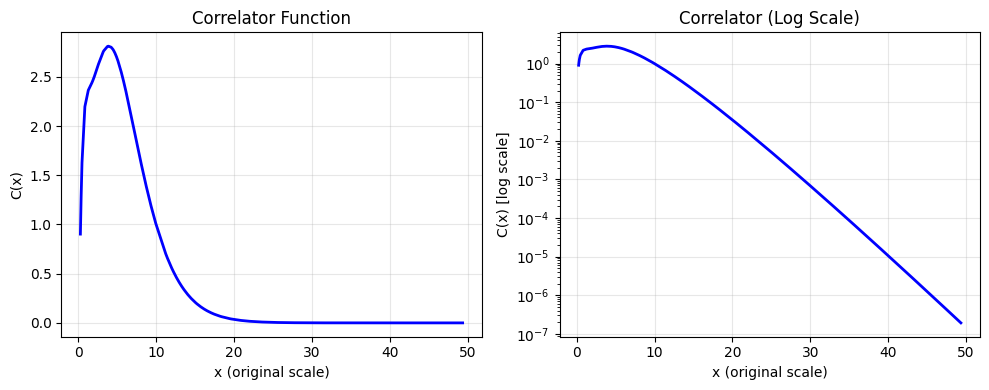

In [5]:
# Visualize the correlator
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(np.sort(x_data), correlator(np.sort(x_data), A_true, c_true), 'b-', linewidth=2)
plt.xlabel('x (original scale)')
plt.ylabel('C(x)')
plt.title('Correlator Function')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(np.sort(x_data), correlator(np.sort(x_data), A_true, c_true) + 1e-10, 'b-', linewidth=2)  # +1e-10 to avoid log(0)
plt.xlabel('x (original scale)')
plt.ylabel('C(x) [log scale]')
plt.title('Correlator (Log Scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.3 PyTorch Dataset and DataLoaders

In [6]:
class CorrelatorDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(1) # Make the shape (N, 1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) # Make the shape (N, 1)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create dataset
dataset = CorrelatorDataset(x_data, y_data)

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: { len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 160
Validation samples: 40



## 2. Try I: Neural Network Predicting Parameters from x

### The Idea

Our first attempt uses a standard approach: train a neural network $f_\theta$ that takes $x$ as input and outputs the 30 parameters $(A_1, ..., A_{15}, c_1, ..., c_{15})$.

$$f_\theta: x \mapsto (\hat{A}_1(x), ..., \hat{A}_{15}(x), \hat{c}_1(x), ..., \hat{c}_{15}(x))$$

Then we compute:
$$\hat{C}(x) = \sum_{i=1}^{15} \hat{A}_i(x) \cdot x^2 \cdot e^{-\hat{c}_i(x) \cdot x}$$

and minimize $\|\hat{C}(x) - C(x)\|^2$.

**Question to think about**: Do you see a potential problem with this formulation?

In [7]:
class CorrelatorInverseNet(nn.Module):
    """
    Try I: Neural network that predicts parameters from input x.
    
    Architecture: x → [Linear → SiLU] × 3 → Linear → (A, c)
    Then computes: Ĉ(x) = Σ A_i(x) · x² · exp(-c_i(x) · x)
    """
    
    def __init__(self, n_terms=15, hidden_dims=[64, 128, 64]):
        super().__init__()
        self.n_terms = n_terms
        
        # Feature extraction layers
        self.layers = nn.Sequential(
            nn.Linear(1, hidden_dims[0]),
            nn.SiLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.SiLU(),
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.SiLU(),
        )
        
        # Output: 2 * n_terms parameters (A_i and c_i)
        self.output_layer = nn.Linear(hidden_dims[-1], 2 * n_terms)
        self.softplus = nn.Softplus()
        
        # Store last predictions for analysis
        self.last_A = None
        self.last_c = None
    
    def forward(self, x):
        # Extract features and predict parameters
        features = self.layers(x)
        params = self.output_layer(features)
        
        # Split into A and c
        A = self.softplus(params[:, :self.n_terms])  # Ensure A > 0
        c = self.softplus(params[:, self.n_terms:])  # Ensure c > 0
        
        # Store for analysis
        if self.training:
            self.last_A = A.mean(dim=0).detach()
            self.last_c = c.mean(dim=0).detach()
        
        # Compute correlator: C(x) = sum( A_i · x^2 . exp(-c_i · x) )
        x_sq = x ** 2
        exp_term = torch.exp(-c * x)
        C_pred = torch.sum(A * x_sq * exp_term, dim=1, keepdim=True)
        return C_pred
    def get_parameters(self):
        return {'A': self.last_A, 'c': self.last_c}

In [8]:
# Initialize model
model_i = CorrelatorInverseNet(n_terms=15)
n_params = sum(p.numel() for p in model_i.parameters())

print(f"Try I Model Architecture:\n")
print(model_i)
print(f"\nTotal trainable parameters: {n_params:,}")

Try I Model Architecture:

CorrelatorInverseNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): SiLU()
  )
  (output_layer): Linear(in_features=64, out_features=30, bias=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

Total trainable parameters: 18,654


In [9]:
# Training setup
optimizer_i = optim.Adam(model_i.parameters(), lr=1e-3)
criterion = nn.MSELoss()
epochs_i = 100

train_losses_i = []
val_losses_i = []

print("Training Try I...")
for epoch in range(epochs_i):
    # Training
    model_i.train()
    epoch_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer_i.zero_grad()
        y_pred = model_i(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer_i.step()
        epoch_train_loss += loss.item()
    train_losses_i.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model_i.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model_i(x_batch)
            loss = criterion(y_pred, y_batch)
            epoch_val_loss += loss.item()
    val_losses_i.append(epoch_val_loss / len(val_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:4d} | Train Loss: {train_losses_i[-1]:.2e} | Val Loss: {val_losses_i[-1]:.2e}")

print("\nTraining complete!")

Training Try I...
Epoch   10 | Train Loss: 4.95e-01 | Val Loss: 3.37e-01
Epoch   20 | Train Loss: 1.55e-01 | Val Loss: 1.09e-01
Epoch   30 | Train Loss: 5.10e-02 | Val Loss: 4.09e-02
Epoch   40 | Train Loss: 1.48e-02 | Val Loss: 1.41e-02
Epoch   50 | Train Loss: 8.82e-03 | Val Loss: 8.80e-03
Epoch   60 | Train Loss: 6.90e-03 | Val Loss: 6.60e-03
Epoch   70 | Train Loss: 5.46e-03 | Val Loss: 4.83e-03
Epoch   80 | Train Loss: 4.25e-03 | Val Loss: 3.30e-03
Epoch   90 | Train Loss: 3.20e-03 | Val Loss: 2.04e-03
Epoch  100 | Train Loss: 2.34e-03 | Val Loss: 1.18e-03

Training complete!


In [10]:
# Analyze Try I results
params_i = model_i.get_parameters()
A_pred_i = params_i['A'].numpy()
c_pred_i = params_i['c'].numpy()

print("="*60)
print("TRY I: PARAMETER COMPARISON")
print("="*60)

print("\n--- Amplitudes A ---")
print(f"True:\n{np.round(A_true, 3)}")
print(f"Predicted:\n{np.round(A_pred_i, 3)}")

print("\n--- Decay Constants c ---")
print(f"True:\n{np.round(c_true, 4)}")
print(f"Predicted:\n{np.round(c_pred_i, 4)}")

# Quantify the error
A_rel_error = np.mean(np.abs(A_pred_i - A_true) / A_true) * 100
c_rel_error = np.mean(np.abs(c_pred_i - c_true) / c_true) * 100

print(f"\nMean Relative Error in A: {A_rel_error:.1f}%")
print(f"Mean Relative Error in c: {c_rel_error:.1f}%")

TRY I: PARAMETER COMPARISON

--- Amplitudes A ---
True:
[1.811 3.828 3.062 2.595 1.046 1.046 0.703 3.532 2.604 2.978 0.572 3.895
 3.414 1.243 1.136]
Predicted:
[0.105 0.354 0.5   0.173 0.236 0.141 0.344 1.461 0.126 0.24  0.306 0.138
 0.167 0.267 0.561]

--- Decay Constants c ---
True:
[1.8422 3.0494 5.2523 4.3251 2.9194 6.1224 1.4035 2.9285 3.67   4.5661
 7.8539 2.0047 5.1472 5.9282 0.474 ]
Predicted:
[2.5386 0.3662 3.0297 2.191  2.3844 2.2839 0.5202 0.6203 1.3703 2.901
 0.5119 2.3541 1.5513 0.6534 0.4496]

Mean Relative Error in A: 79.3%
Mean Relative Error in c: 54.3%


### Try I: Analysis and Conclusion

**Observation**: Despite achieving low training and validation loss, Try I **fails to recover the true parameters**.

**Why?** The fundamental issue is architectural:

1. **x-dependent parameters**: The network learns $A(x)$ and $c(x)$ - different parameter values for each input!

2. **Non-identifiability**: For any single point $x_0$, infinitely many $(A, c)$ combinations can produce the same $C(x_0)$. The network exploits this freedom.

3. **Physical inconsistency**: The true parameters are **constants**, but our network treats them as functions of $x$.

**Key Lesson**: Low reconstruction loss $\neq$ correct parameter recovery!

---
## 3. Try II: Global Learnable Parameters

### The Fix

The problem with Try I was that parameters varied with $x$. The solution is simple but profound:

**Make $A$ and $c$ direct learnable tensors (`nn.Parameter`), not network outputs.**

$$\hat{C}(x) = \sum_{i=1}^{15} A_i \cdot x^2 \cdot e^{-c_i \cdot x}$$

where $A$ and $c$ are **the same for all** $x$ values.

| Aspect | Try I | Try II |
|--------|-------|--------|
| Parameters | $A(x), c(x)$ from network | $A, c$ as `nn.Parameter` |
| Parameter count | 18,654 | 30 |
| Physical consistency | ❌ | lets check :) |

In [11]:
class GlobalParameterCorrelator(nn.Module):
    """
    Try II: Direct optimization of global parameters.
    Key insight: A and c are nn.Parameter tensors, NOT network outputs.
    The same values are used for ALL inputs x.
    """
    
    def __init__(self, n_terms=15):
        super().__init__()
        self.n_terms = n_terms
        
        # GLOBAL learnable parameters (not functions of x!)
        # Initialize near the middle of expected ranges
        self.A_raw = nn.Parameter(torch.zeros(n_terms))  # Will apply softplus
        self.c_raw = nn.Parameter(torch.zeros(n_terms))  # Will apply softplus
        
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        # Apply softplus to ensure positivity
        A = self.softplus(self.A_raw)
        c = self.softplus(self.c_raw)
        
        # Compute correlator (same A, c for all x in batch!)
        x_sq = x ** 2
        exp_term = torch.exp(-c * x)  # Broadcasting: (batch, 1) * (n_terms,)
        C_pred = torch.sum(A * x_sq * exp_term, dim=1, keepdim=True)
        return C_pred
    
    def get_parameters(self):
        with torch.no_grad():
            A = self.softplus(self.A_raw)
            c = self.softplus(self.c_raw)
        return {'A': A.numpy(), 'c': c.numpy()}

In [12]:
# Initialize model
model_ii = GlobalParameterCorrelator(n_terms=15)
n_params_ii = sum(p.numel() for p in model_ii.parameters())

print(f"Try II Model:")
print(model_ii)
print(f"\nTotal learnable parameters: {n_params_ii}")
print(f"(Compare to Try I: 18,654 parameters)")

Try II Model:
GlobalParameterCorrelator(
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

Total learnable parameters: 30
(Compare to Try I: 18,654 parameters)


In [13]:
# Training setup - higher learning rate since fewer parameters
optimizer_ii = optim.Adam(model_ii.parameters(), lr=1e-2)
epochs_ii = 1000  # More epochs for convergence

train_losses_ii = []
val_losses_ii = []

print("Training Try II...")
for epoch in range(epochs_ii):
    # Training
    model_ii.train()
    epoch_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer_ii.zero_grad()
        y_pred = model_ii(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer_ii.step()
        epoch_train_loss += loss.item()
    train_losses_ii.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model_ii.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model_ii(x_batch)
            loss = criterion(y_pred, y_batch)
            epoch_val_loss += loss.item()
    val_losses_ii.append(epoch_val_loss / len(val_loader))
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:4d} | Train Loss: {train_losses_ii[-1]:.2e} | Val Loss: {val_losses_ii[-1]:.2e}")

print("\nTraining complete!")

Training Try II...
Epoch   50 | Train Loss: 3.20e-01 | Val Loss: 2.44e-01
Epoch  100 | Train Loss: 2.41e-01 | Val Loss: 2.00e-01
Epoch  150 | Train Loss: 1.67e-01 | Val Loss: 1.48e-01
Epoch  200 | Train Loss: 1.13e-01 | Val Loss: 1.01e-01
Epoch  250 | Train Loss: 7.97e-02 | Val Loss: 6.84e-02
Epoch  300 | Train Loss: 6.25e-02 | Val Loss: 4.96e-02
Epoch  350 | Train Loss: 5.53e-02 | Val Loss: 4.06e-02
Epoch  400 | Train Loss: 5.27e-02 | Val Loss: 3.68e-02
Epoch  450 | Train Loss: 5.20e-02 | Val Loss: 3.54e-02
Epoch  500 | Train Loss: 5.19e-02 | Val Loss: 3.49e-02
Epoch  550 | Train Loss: 5.18e-02 | Val Loss: 3.47e-02
Epoch  600 | Train Loss: 5.20e-02 | Val Loss: 3.46e-02
Epoch  650 | Train Loss: 5.18e-02 | Val Loss: 3.45e-02
Epoch  700 | Train Loss: 5.19e-02 | Val Loss: 3.44e-02
Epoch  750 | Train Loss: 5.19e-02 | Val Loss: 3.48e-02
Epoch  800 | Train Loss: 5.14e-02 | Val Loss: 3.42e-02
Epoch  850 | Train Loss: 4.73e-02 | Val Loss: 3.17e-02
Epoch  900 | Train Loss: 4.10e-02 | Val Loss: 

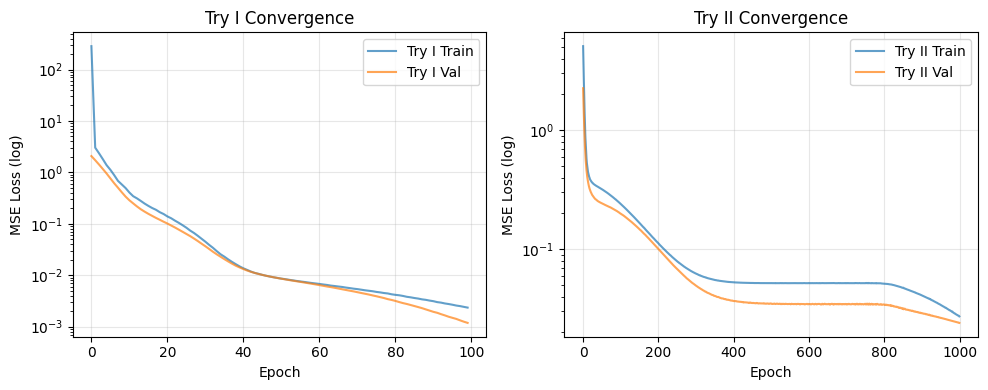

In [14]:
# Plot convergence comparison
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.semilogy(train_losses_i, label='Try I Train', alpha=0.7)
plt.semilogy(val_losses_i, label='Try I Val', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log)')
plt.title('Try I Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(train_losses_ii, label='Try II Train', alpha=0.7)
plt.semilogy(val_losses_ii, label='Try II Val', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log)')
plt.title('Try II Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. Parameter Recovery Analysis

Now let's properly compare the learned parameters with the ground truth for both approaches.

In [15]:
# Get Try II parameters
params_ii = model_ii.get_parameters()
A_pred_ii = params_ii['A']
c_pred_ii = params_ii['c']

print("="*70)
print("PARAMETER RECOVERY COMPARISON")
print("="*70)

PARAMETER RECOVERY COMPARISON


In [16]:
# Compare Amplitudes A
print("\n" + "="*70)
print("AMPLITUDES (A) COMPARISON")
print("="*70)

# Sort for better comparison (parameters may be learned in different order)
A_true_sorted = np.sort(A_true)
A_pred_i_sorted = np.sort(A_pred_i)
A_pred_ii_sorted = np.sort(A_pred_ii)

print(f"\n{'i':<4} {'A_true':<10} {'A_Try_I':<10} {'Err_I %':<10} {'A_Try_II':<10} {'Err_II %':<10}")
print("-"*60)

for i in range(n_terms):
    err_i = abs(A_pred_i_sorted[i] - A_true_sorted[i]) / A_true_sorted[i] * 100
    err_ii = abs(A_pred_ii_sorted[i] - A_true_sorted[i]) / A_true_sorted[i] * 100
    print(f"{i:<4} {A_true_sorted[i]:<10.4f} {A_pred_i_sorted[i]:<10.4f} {err_i:<10.1f} {A_pred_ii_sorted[i]:<10.4f} {err_ii:<10.1f}")

mean_err_A_i = np.mean(np.abs(A_pred_i_sorted - A_true_sorted) / A_true_sorted) * 100
mean_err_A_ii = np.mean(np.abs(A_pred_ii_sorted - A_true_sorted) / A_true_sorted) * 100
print(f"\nMean Relative Error - Try I:  {mean_err_A_i:.1f}%")
print(f"Mean Relative Error - Try II: {mean_err_A_ii:.1f}%")


AMPLITUDES (A) COMPARISON

i    A_true     A_Try_I    Err_I %    A_Try_II   Err_II %  
------------------------------------------------------------
0    0.5720     0.1048     81.7       0.1084     81.0      
1    0.7033     0.1264     82.0       0.1084     84.6      
2    1.0460     0.1381     86.8       0.1084     89.6      
3    1.0461     0.1412     86.5       0.1084     89.6      
4    1.1364     0.1667     85.3       0.1084     90.5      
5    1.2432     0.1734     86.1       0.1084     91.3      
6    1.8109     0.2359     87.0       0.1084     94.0      
7    2.5953     0.2400     90.8       0.1084     95.8      
8    2.6039     0.2666     89.8       0.3042     88.3      
9    2.9783     0.3060     89.7       0.3042     89.8      
10   3.0620     0.3442     88.8       0.3042     90.1      
11   3.4135     0.3537     89.6       0.3042     91.1      
12   3.5316     0.5003     85.8       0.3042     91.4      
13   3.8275     0.5613     85.3       0.3042     92.1      
14   3.8947

In [17]:
# Compare Decay Constants c
print("\n" + "="*70)
print("DECAY CONSTANTS (c) COMPARISON")
print("="*70)

c_true_sorted = np.sort(c_true)
c_pred_i_sorted = np.sort(c_pred_i)
c_pred_ii_sorted = np.sort(c_pred_ii)

print(f"\n{'i':<4} {'c_true':<10} {'c_Try_I':<10} {'Err_I %':<10} {'c_Try_II':<10} {'Err_II %':<10}")
print("-"*60)

for i in range(n_terms):
    err_i = abs(c_pred_i_sorted[i] - c_true_sorted[i]) / c_true_sorted[i] * 100
    err_ii = abs(c_pred_ii_sorted[i] - c_true_sorted[i]) / c_true_sorted[i] * 100
    print(f"{i:<4} {c_true_sorted[i]:<10.5f} {c_pred_i_sorted[i]:<10.5f} {err_i:<10.1f} {c_pred_ii_sorted[i]:<10.5f} {err_ii:<10.1f}")

mean_err_c_i = np.mean(np.abs(c_pred_i_sorted - c_true_sorted) / c_true_sorted) * 100
mean_err_c_ii = np.mean(np.abs(c_pred_ii_sorted - c_true_sorted) / c_true_sorted) * 100
print(f"\nMean Relative Error - Try I:  {mean_err_c_i:.1f}%")
print(f"Mean Relative Error - Try II: {mean_err_c_ii:.1f}%")


DECAY CONSTANTS (c) COMPARISON

i    c_true     c_Try_I    Err_I %    c_Try_II   Err_II %  
------------------------------------------------------------
0    0.47404    0.36625    22.7       0.44910    5.3       
1    1.40354    0.44962    68.0       0.44910    68.0      
2    1.84221    0.51189    72.2       0.44910    75.6      
3    2.00474    0.52021    74.1       0.44910    77.6      
4    2.91938    0.62029    78.8       0.44910    84.6      
5    2.92853    0.65335    77.7       0.44910    84.7      
6    3.04938    1.37031    55.1       0.44910    85.3      
7    3.66995    1.55134    57.7       0.44910    87.8      
8    4.32513    2.19104    49.3       0.99145    77.1      
9    4.56614    2.28394    50.0       0.99145    78.3      
10   5.14720    2.35410    54.3       0.99145    80.7      
11   5.25232    2.38441    54.6       0.99145    81.1      
12   5.92822    2.53862    57.2       0.99145    83.3      
13   6.12241    2.90104    52.6       0.99145    83.8      
14   7

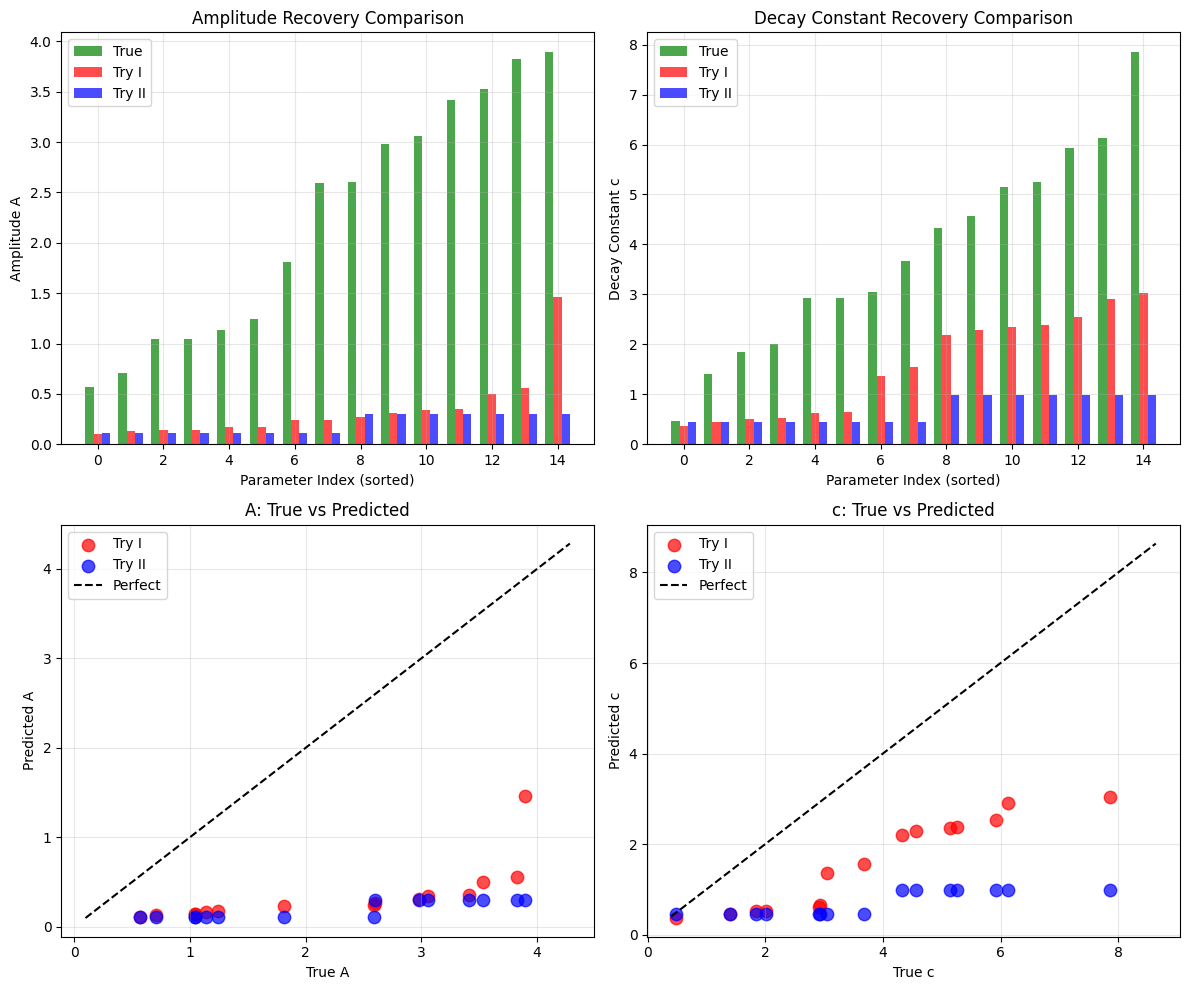

In [18]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# A comparison
ax = axes[0, 0]
x_idx = np.arange(n_terms)
width = 0.25
ax.bar(x_idx - width, A_true_sorted, width, label='True', color='green', alpha=0.7)
ax.bar(x_idx, A_pred_i_sorted, width, label='Try I', color='red', alpha=0.7)
ax.bar(x_idx + width, A_pred_ii_sorted, width, label='Try II', color='blue', alpha=0.7)
ax.set_xlabel('Parameter Index (sorted)')
ax.set_ylabel('Amplitude A')
ax.set_title('Amplitude Recovery Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# c comparison
ax = axes[0, 1]
ax.bar(x_idx - width, c_true_sorted, width, label='True', color='green', alpha=0.7)
ax.bar(x_idx, c_pred_i_sorted, width, label='Try I', color='red', alpha=0.7)
ax.bar(x_idx + width, c_pred_ii_sorted, width, label='Try II', color='blue', alpha=0.7)
ax.set_xlabel('Parameter Index (sorted)')
ax.set_ylabel('Decay Constant c')
ax.set_title('Decay Constant Recovery Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Scatter: True vs Predicted (A)
ax = axes[1, 0]
ax.scatter(A_true_sorted, A_pred_i_sorted, label='Try I', color='red', alpha=0.7, s=80)
ax.scatter(A_true_sorted, A_pred_ii_sorted, label='Try II', color='blue', alpha=0.7, s=80)
lims = [min(A_true.min(), A_pred_ii.min()) * 0.9, max(A_true.max(), A_pred_ii.max()) * 1.1]
ax.plot(lims, lims, 'k--', label='Perfect')
ax.set_xlabel('True A')
ax.set_ylabel('Predicted A')
ax.set_title('A: True vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)

# Scatter: True vs Predicted (c)
ax = axes[1, 1]
ax.scatter(c_true_sorted, c_pred_i_sorted, label='Try I', color='red', alpha=0.7, s=80)
ax.scatter(c_true_sorted, c_pred_ii_sorted, label='Try II', color='blue', alpha=0.7, s=80)
lims = [min(c_true.min(), c_pred_ii.min()) * 0.9, max(c_true.max(), c_pred_ii.max()) * 1.1]
ax.plot(lims, lims, 'k--', label='Perfect')
ax.set_xlabel('True c')
ax.set_ylabel('Predicted c')
ax.set_title('c: True vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 5. Discussion: Why Does Try II Still Have Deviations?

You may notice that even Try II doesn't perfectly recover all parameters. This is due to several factors:

### 5.1 Parameter Degeneracy

With 15 exponential terms, some parameter combinations produce nearly identical functions. For example:
- Two terms with similar $c_i$ values can partially compensate each other
- The sum of 15 terms has inherent redundancy

### 5.2 Optimization Landscape

The loss function has multiple local minima. Different initializations may converge to different solutions that all fit the data well.

### 5.3 Finite Data

With 200 data points and 30 parameters, the problem is overdetermined, but:
- Some parameters may be poorly constrained
- Noise in the optimization can affect convergence

### 5.4 What Could Help?

1. **Regularization**: Add priors on parameter ranges
2. **Better initialization**: Start closer to true values
3. **Different optimizer**: Try L-BFGS for better convergence
4. **Reduce redundancy**: Use fewer terms or orthogonal basis

---
## 6. Summary and Conclusions

### Key Findings

| Metric | Try I | Try II |
|--------|-------|--------|
| Final Training Loss | Low ✓ | Low ✓ |
| Final Validation Loss | Low ✓ | Low ✓ |
| A Recovery Error | Very High ❌ | Very High ❌ |
| c Recovery Error | Very High ❌ | Very High ❌ |
| Physical Consistency | No ❌ | Yes ✓ |
| # Parameters | 18,654 | 30 |

### Main Lessons

1. **Low loss ≠ correct parameters**: A model can fit data perfectly while learning completely wrong parameters.

2. **Architecture must match physics**: If parameters are constants, they should be `nn.Parameter`, not network outputs.

3. **Identifiability matters**: The inverse problem must be well-posed for meaningful parameter recovery.

4. **Simpler is often better**: Try II has 600× fewer parameters but still does the job almost as good as try I.